マスク着用判定アプリ開発コース（トレーニングから静止画判定まで）


ライブラリのインポート

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt


KaggleのAPIキーをセット

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "ユーザー名"
os.environ['KAGGLE_KEY'] = "APIキー"

データのダウンロード

In [ ]:
!kaggle datasets download -d prithwirajmitra/covid-face-mask-detection-dataset

100% 207M/207M [00:01<00:00, 108MB/s]



ファイルの解凍

In [ ]:
! unzip covid-face-mask-detection-dataset.zip

Archive:  covid-face-mask-detection-dataset.zip
  inflating: New Masks Dataset/Test/Mask/2070.jpg  
  inflating: New Masks Dataset/Test/Mask/2072.jpg  
  inflating: New Masks Dataset/Test/Mask/2083.jpg  
  inflating: New Masks Dataset/Test/Mask/2085.jpg  
  inflating: New Masks Dataset/Test/Mask/2086.jpg  
  inflating: New Masks Dataset/Test/Mask/2110.jpg  
  inflating: New Masks Dataset/Test/Mask/2113.jpg  
  inflating: New Masks Dataset/Test/Mask/2114.jpeg  
  inflating: New Masks Dataset/Test/Mask/2130.jpg  
  inflating: New Masks Dataset/Test/Mask/2132.jpg  
  inflating: New Masks Dataset/Test/Mask/2135.jpg  
  inflating: New Masks Dataset/Test/Mask/2154.png  
  inflating: New Masks Dataset/Test/Mask/2158.png  
  inflating: New Masks Dataset/Test/Mask/2159.png  
  inflating: New Masks Dataset/Test/Mask/2160.png  
  inflating: New Masks Dataset/Test/Mask/2170.png  
  inflating: New Masks Dataset/Test/Mask/2172.png  
  inflating: New Masks Dataset/Test/Mask/2173.png  
  inflating: Ne

ファイルパスの定義

In [ ]:
base_dir = '/content/New Masks Dataset'
train_dir = os.path.join(base_dir,'Train')
test_dir = os.path.join(base_dir,'Test')
valid_dir = os.path.join(base_dir,'Validation')

train_mask_dir = os.path.join(train_dir,"Mask")
train_nomask_dir = os.path.join(train_dir, 'Non Mask')


In [ ]:
train_mask_files = os.listdir(train_mask_dir)
print(train_mask_files[:10])

['0037.jpg', '0048.jpg', '0650.jpg', '0913.jpg', '0170.jpg', '1555.jpg', '0777.jpg', '0577.jpg', '1037.png', '0273.jpg']


In [ ]:
train_nomask_files = os.listdir(train_nomask_dir)
print(train_nomask_files[:10])

['115.jpg', '174.jpg', '12.jpg', '99.jpg', '193.jpg', '181.jpg', '105.jpg', '148.jpg', '233.jpg', '308.jpg']


画像を配列に格納


In [ ]:
import matplotlib.image as mpimg
nrows = 4
ncols = 4
plt.figure(figsize=(12,12))

mask_images = []
for i in train_mask_files[0:8]:
  mask_images.append(os.path.join(train_mask_dir,i))

nomask_images =[]
for i in train_nomask_files[0:8]:
  mask_images.append(os.path.join(train_nomask_dir,i))

print(mask_images)
print(nomask_images)


['/content/New Masks Dataset/Train/Mask/0037.jpg', '/content/New Masks Dataset/Train/Mask/0048.jpg', '/content/New Masks Dataset/Train/Mask/0650.jpg', '/content/New Masks Dataset/Train/Mask/0913.jpg', '/content/New Masks Dataset/Train/Mask/0170.jpg', '/content/New Masks Dataset/Train/Mask/1555.jpg', '/content/New Masks Dataset/Train/Mask/0777.jpg', '/content/New Masks Dataset/Train/Mask/0577.jpg', '/content/New Masks Dataset/Train/Non Mask/115.jpg', '/content/New Masks Dataset/Train/Non Mask/174.jpg', '/content/New Masks Dataset/Train/Non Mask/12.jpg', '/content/New Masks Dataset/Train/Non Mask/99.jpg', '/content/New Masks Dataset/Train/Non Mask/193.jpg', '/content/New Masks Dataset/Train/Non Mask/181.jpg', '/content/New Masks Dataset/Train/Non Mask/105.jpg', '/content/New Masks Dataset/Train/Non Mask/148.jpg']
[]


<Figure size 864x864 with 0 Axes>

画像を１つの配列に格納

In [ ]:
merged_images = mask_images + nomask_images

画像を可視化

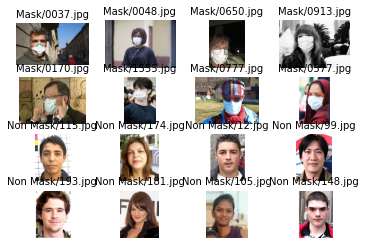

In [ ]:
for i in range(0,len(merged_images)):
  data = merged_images[i].split('/',4)[4]
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('Off')
  image = mpimg.imread(merged_images[i])
  sp.set_title(data, fontsize=10)
  plt.imshow(image, cmap='gray')

plt.show()


データイメージジェネレータの定義

In [ ]:
train_datagenerator = ImageDataGenerator(rescale=1./255,
                                         zoom_range = 0.2,
                                         rotation_range = 50,
                                         horizontal_flip = True
                                         )

In [ ]:
test_datagenerator = ImageDataGenerator(rescale=1./255)
valid_datagenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagenerator.flow_from_directory(train_dir,
                                                          target_size=(150,150),
                                                          batch_size = 32,
                                                          class_mode = 'binary')
test_generator = test_datagenerator.flow_from_directory(test_dir,
                                                          target_size=(150,150),
                                                          batch_size = 32,
                                                          class_mode = 'binary')
valid_generator = valid_datagenerator.flow_from_directory(valid_dir,
                                                          target_size=(150,150),
                                                          batch_size = 32,
                                                          class_mode = 'binary')

Found 600 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 306 images belonging to 2 classes.


クラスラベルの確認

In [ ]:
train_generator.class_indices

{'Mask': 0, 'Non Mask': 1}

データ形状の確認

In [ ]:
train_generator.image_shape

(150, 150, 3)

AIモデルの定義


In [ ]:
model = Sequential()
model.add(Conv2D(32,(3,3), padding='SAME', activation='relu', input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64,(3,3), padding='SAME', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 87616)             0

Compileとトレーニングの実行


最適化手法の設定

In [ ]:
model.compile(Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

トレーニングの実行

In [ ]:
history = model.fit(train_generator,
                    epochs = 30,
                    validation_data=valid_generator)

Epoch 1/30
19/19 [==============================] - 44s 713ms/step - loss: 2.8997 - accuracy: 0.5233 - val_loss: 0.6848 - val_accuracy: 0.6438
Epoch 2/30
19/19 [==============================] - 13s 692ms/step - loss: 0.5700 - accuracy: 0.7400 - val_loss: 0.6111 - val_accuracy: 0.7941
Epoch 3/30
19/19 [==============================] - 13s 697ms/step - loss: 0.4103 - accuracy: 0.8467 - val_loss: 0.4880 - val_accuracy: 0.8464
Epoch 4/30
19/19 [==============================] - 13s 717ms/step - loss: 0.3114 - accuracy: 0.8733 - val_loss: 0.3255 - val_accuracy: 0.9052
Epoch 5/30
19/19 [==============================] - 14s 740ms/step - loss: 0.2834 - accuracy: 0.8917 - val_loss: 0.3314 - val_accuracy: 0.9118
Epoch 6/30
19/19 [==============================] - 14s 764ms/step - loss: 0.2760 - accuracy: 0.8967 - val_loss: 0.3176 - val_accuracy: 0.9118
Epoch 7/30
19/19 [==============================] - 14s 745ms/step - loss: 0.2364 - accuracy: 0.9167 - val_loss: 0.2806 - val_accuracy: 0.8922

ロス（損失）の収束具合をプロット

Text(0.5, 0, 'epoch')

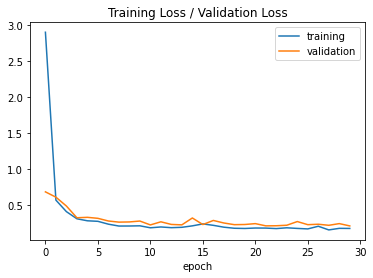

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Training Loss / Validation Loss')
plt.xlabel('epoch')

精度の収束具合をプロット

Text(0.5, 0, 'epoch')

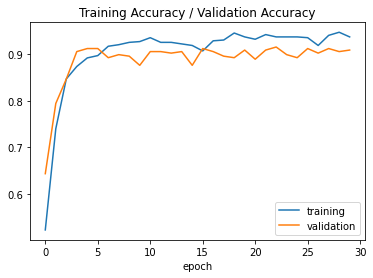

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Training Accuracy / Validation Accuracy')
plt.xlabel('epoch')

画像から推定するプログラム


In [ ]:
from google.colab import files
from keras.preprocessing import image
uploaded = files.upload()
for filename in uploaded.keys():
  image_path = '/content/' + filename
  img = image.load_img(image_path, target_size=(150,150))
  images = image.img_to_array(img)
  images = np.expand_dims(images, axis=0)
  prediction = model.predict(images)
  print(filename)
  if prediction == 0:
    print('With Mask')

  else:
    print('No Mask')

Saving nomask.jpg to nomask.jpg
nomask.jpg
No Mask


モデルを保存

In [ ]:
model.save('maskmodel.h5')